In [82]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from beerai.config import DATA_DIR

In [110]:
%matplotlib inline

In [5]:
with pd.HDFStore(os.path.join(DATA_DIR, "interim/all_recipes.h5")) as store:
    core = store.get("core")
    ings = store.get("ingredients")

In [6]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
0,18.927059,21.198306,60.0,velkyal,0.75,dark island oir leann,brewtoad,recipes/brewtoad/dark-island-oir-leann.xml,NaN,NaN,NaN,NaN,NaN,6b,bjcp,blonde ale,1.0
1,22.712471,28.390588,60.0,wain thor,0.85,witbur,brewtoad,recipes/brewtoad/witbur.xml,NaN,NaN,NaN,NaN,NaN,6d,bjcp,american wheat or rye beer,1.0
2,20.819765,24.983718,60.0,btfielder,0.75,kolsch,brewtoad,recipes/brewtoad/kolsch-9285a4.xml,NaN,NaN,NaN,NaN,NaN,6c,bjcp,kölsch,1.0
3,18.927059,23.658824,60.0,viff brewing,0.75,amber alert,brewtoad,recipes/brewtoad/amber-alert-4.xml,NaN,NaN,NaN,NaN,NaN,10b,bjcp,american amber ale,1.0
4,18.927059,23.658824,60.0,pistolpete2,0.75,graff,brewtoad,recipes/brewtoad/graff-14.xml,NaN,NaN,NaN,NaN,NaN,20a,bjcp,fruit beer,1.0


In [34]:
map_files = glob.glob(os.path.join(DATA_DIR, "interim/*map.pickle"))
map_files = {os.path.basename(m)[:-10]: m for m in map_files}

maps = {}
for label, map_file in map_files.items():
    with open(map_file, "rb") as f:
        maps[label] = pickle.load(f)

In [36]:
ings["ferm_name"] = ings["ferm_name"].map(maps["ferm"])
ings["hop_name"] = ings["hop_name"].map(maps["hop"])
ings["yeast_name"] = ings["yeast_name"].map(maps["yeast"])
ings["misc_name"] = ings["misc_name"].map(maps["misc"])

In [55]:
styles = ["robust porter", "american stout"]

In [56]:
recipe_ids = core[core["style_name"].isin(styles)].index

In [57]:
stouts =  core.loc[recipe_ids].join(ings, how="left")

In [58]:
stouts.index.nunique()

16895

In [173]:
rp = stouts[stouts.style_name == "robust porter"].ferm_name.value_counts(normalize=True)
rp.name = "robust porter"
rp = pd.DataFrame(rp)

In [174]:
ast = stouts[stouts.style_name == "american stout"].ferm_name.value_counts(normalize=True)
ast.name = "american stout"
ast = pd.DataFrame(ast)

In [175]:
stout_ferms = rp.join(ast, how="outer")

In [191]:
stout_ferms["tot"] = stout_ferms.sum(axis=1)
stout_ferms = stout_ferms.sort_values("tot")

In [192]:
stout_ferms = stout_ferms.tail(20)
stout_ferms

,robust porter,american stout,tot
white wheat,0.011574,0.011574,0.069444
brown malt,0.018876,0.005022,0.071693
special b,0.014662,0.009924,0.073758
pale chocolate,0.014157,0.011885,0.078125
munich malt,0.021401,0.008561,0.089884
liquid malt extract - light,0.017847,0.013415,0.093786
dry malt extract - light,0.017944,0.014802,0.098238
flaked barley,0.013380,0.026615,0.119987
carapils® malt,0.025828,0.019657,0.136455
caramel malt 40l,0.033266,0.021163,0.163287


<AxesSubplot:>

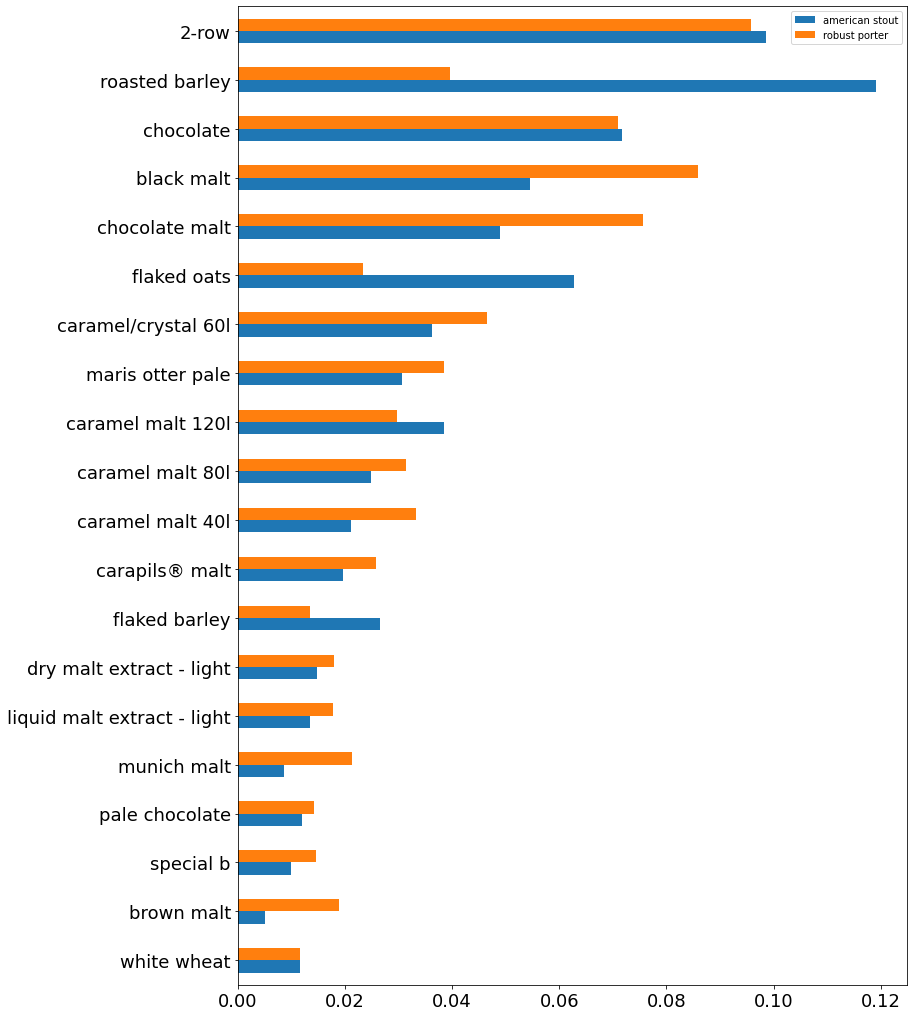

In [203]:
stout_ferms[["american stout", "robust porter"]].plot(kind="barh", stacked=False, figsize=(12,18), fontsize=18)